In [16]:
import json
import pandas as pd
import seaborn as sb
import numpy as np
import re
import matplotlib.pyplot as plt

In [2]:
def load_json_data(file_path):
    """Loads JSON data from a file."""
    with open(file_path, 'r') as file:
        data = json.load(file)
    return data

In [3]:
def flatten_data(data):
    flattened_data = []
    submetrics_to_disregard = ['domloading', 'navigationStart']

    for website, metrics in data['sites'].items():
        for metric, value in metrics.items():
            if metric == 'navigationTiming':
                for sub_metric, sub_value in value.items():
                    if sub_metric not in submetrics_to_disregard and sub_value is not None:
                        flattened_data.append({
                            'website': website,
                            'metric': f'navigationTiming_{sub_metric}',
                            'value': sub_value
                        })
            elif metric != 'dnsLookupTimes':
                flattened_data.append({
                    'website': website,
                    'metric': metric,
                    'value': value
                })
    
    return flattened_data

In [4]:
def calculate_avg_and_mean(data, w_or_wo_ublock):
    flattened_data = flatten_data(data)
    df = pd.DataFrame(flattened_data)
    summary_stats = df.groupby('metric')['value'].agg(['mean', 'median'])
    #summary_stats = summary_stats.reset_index()

    print(summary_stats)
    summary_stats.to_csv(f'stats_{w_or_wo_ublock}.csv')

In [5]:
data_w_ublock = load_json_data('../json_files/5000_with_ublock.json')
data_wo_ublock = load_json_data('../json_files/filtered_data_no_ublock.json')

calculate_avg_and_mean(data_w_ublock, 'w_ublock')
calculate_avg_and_mean(data_wo_ublock, 'wo_ublock')



                                                     mean      median
metric                                                               
estimatedTBT                                 14006.630941   8640.1728
fcp                                          12342.971946   8533.5040
navigationTiming_connectEnd                   7034.457333   4516.7570
navigationTiming_connectStart                 4282.386004   2400.0480
navigationTiming_domComplete                 23336.077890  14400.2880
navigationTiming_domContentLoadedEventEnd    14159.040293   9316.8530
navigationTiming_domContentLoadedEventStart  14134.695349   9300.1860
navigationTiming_domInteractive              12909.753621   8633.5060
navigationTiming_domainLookupEnd              4243.681747   2366.7140
navigationTiming_domainLookupStart            4243.681747   2366.7140
navigationTiming_fetchStart                   4243.681747   2366.7140
navigationTiming_loadEventEnd                23344.384902  14400.2880
navigationTiming_loa

In [5]:
def search_log_file(log_file_path, search_term, output_file_path):
    with open(log_file_path, 'r') as log_file, open(output_file_path, 'a') as output_file:
        for line in log_file:
            if re.search(search_term, line):
                output_file.write(line)


In [9]:
log_filename = input("Enter filename of the log file to use: ")
log_file_path = f'/media/gilbert/The Citadel/tor_logs/{log_filename}'
search_term = input("Enter search term: ")
output_file_path = f'../log_analysis/{search_term}.txt'

search_log_file(log_file_path, search_term, output_file_path)

In [19]:
def circuit_build_times_histogram(build_times_file, output_file):
    build_times = []
    outlier_value = 2147483646
    outlier_count = 0

    with open(build_times_file, 'r') as file:
        for line in file:
            match = re.search(r"circuit_build_times_add_time\(\): Adding circuit build time (\d+\.?\d*)", line)
            if match:
                # print(line)
                build_time = float(match.group(1))
                if build_time != outlier_value:
                    build_times.append(build_time)
                else:
                    outlier_count += 1
    # print(build_times)
    print(f'Number of outliers: {outlier_count}')
    # print('Creating Dataframe')
    df = pd.DataFrame(build_times, columns=['Build Time'])
    # print('setting theme')
    plt.figure(figsize=(12,6))
    sb.set_theme()
    # print('creating variable ax')
    # if np.isnan(build_times).any():
    #     print('NaN values found, removing...')
    #     build_times = [x for x in build_times if not np.isnan(x)]

    # print(f'Minimum build time: {np.min(build_times)}')
    # print(f'Maximum build time: {np.max(build_times)}')
    # print(f'Mean build time: {np.mean(build_times)}')
    ax = sb.histplot(data=df, x='Build Time', kde=True)
    # print('set title and labels')
    ax.set_title('Distribution of Circuit Build Times')
    ax.set_xlabel('Build Time')
    ax.set_ylabel('Frequency')
    # print('showing plot')

    for p in ax.patches:
        ax.annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 5), textcoords="offset points")
    ax.figure.show()

    plt.savefig(output_file)

    

Number of outliers: 2


/tmp/ipykernel_103006/3842088792.py:40: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  ax.figure.show()


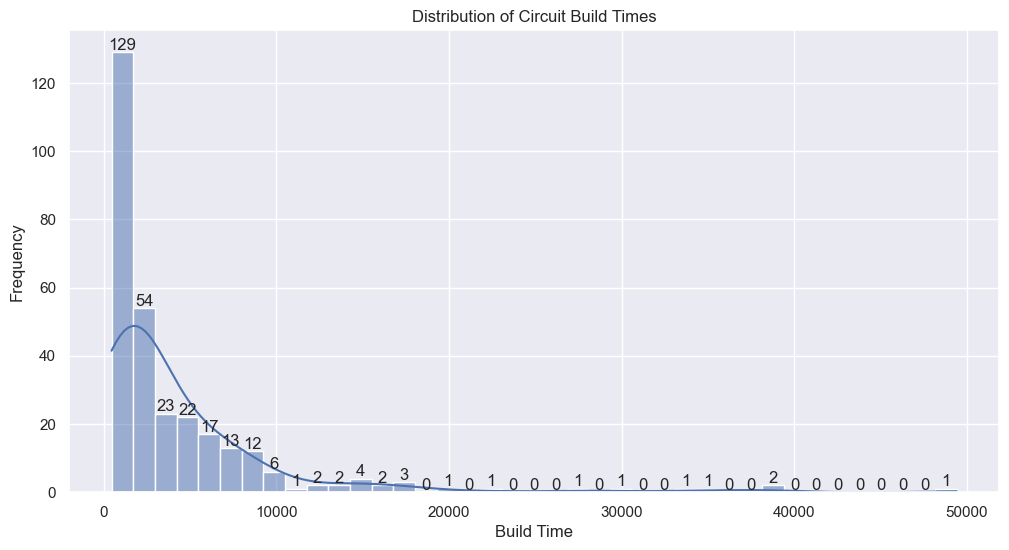

In [21]:
build_times_filename = input("Enter filename of the build times file to use: ")
build_times_file = f'../log_analysis/{build_times_filename}'
output_file = f'../log_analysis/{build_times_filename}.png'
circuit_build_times_histogram(build_times_file, output_file)